#  Make draws form arb dist

In [62]:
import itertools

import matplotlib.pyplot as plt
import matplotlib as mpl
from pymc3 import Model, Normal, Slice
from pymc3 import sample
from pymc3 import traceplot
from pymc3.distributions import Interpolated
from theano import as_op
import theano.tensor as tt
import numpy as np
from scipy import stats
import tqdm
import pandas as pd

%matplotlib inline

%load_ext version_information

%version_information pymc3, scipy



The version_information extension is already loaded. To reload it, use:
  %reload_ext version_information


Software versions
Python 3.6.2 64bit [GCC 4.2.1 Compatible Apple LLVM 6.0 (clang-600.0.57)]
IPython 6.1.0
OS Darwin 15.6.0 x86_64 i386 64bit
pymc3 3.1
scipy 0.19.1
Mon Sep 18 16:34:30 2017 MDT

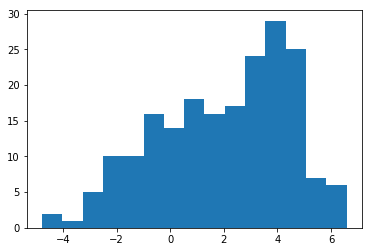

In [52]:
np.random.seed(8675309)
x = stats.norm.rvs(loc=0, scale=2, size=100)
x = np.append(x, stats.norm.rvs(loc=4, scale=1, size=100))
plt.hist(x, 15, normed=False);


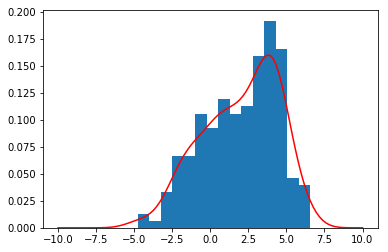

In [53]:
# fit a gaussian kde
kde = stats.gaussian_kde(x)

xx = np.linspace(-10,10, 100)
plt.hist(x, 15, normed=True);
plt.plot(xx, kde.evaluate(xx), c='r')


## Brute force draw

In [54]:
def brute_force_draw(kde, xlim=(-10, 10), ylim=(0.0,.2), N=1000):
    samp = []
    while len(samp) < N:
        x = np.random.uniform(xlim[0], xlim[1], size=N*2)
        y = np.random.uniform(ylim[0], ylim[1], size=N*2)
        ind = kde.evaluate(x) >= y
        samp.extend(x[ind])
    samp = samp[:N]
    return  np.asarray(samp)



a = brute_force_draw(kde, N=30)
a, a.shape

(array([ 1.44720382, -1.71361794,  3.86976315,  3.25491413,  5.01536899,
        -3.92613852,  3.07717371, -2.58155544,  3.96060607,  2.58600679,
         4.76246047,  4.77344481, -1.73908732,  4.4657481 ,  5.46449549,
         1.34482137, -1.78096746, -0.95476455,  3.82152142,  3.42466047,
        -2.92877988, -0.49875371,  1.46424991,  0.01999758, -0.2549366 ,
         1.05183601,  1.93340442,  4.04922727,  4.57114483,  5.08852731]),
 (30,))

In [55]:
%timeit(brute_force_draw(kde, N=10))
%timeit(brute_force_draw(kde, N=100))
%timeit(brute_force_draw(kde, N=1000))
%timeit(brute_force_draw(kde, N=10000))


1.7 ms ± 32.3 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
13.1 ms ± 377 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
25.2 ms ± 1.66 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
166 ms ± 15.6 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


(array([ 0.00037604,  0.00329032,  0.00874285,  0.02340826,  0.04935477,
         0.07793353,  0.0920349 ,  0.10519617,  0.1230579 ,  0.14326985,
         0.16009748,  0.10538419,  0.03760364,  0.00968294,  0.00065806]),
 array([-7.09472796, -6.03100101, -4.96727407, -3.90354712, -2.83982018,
        -1.77609323, -0.71236629,  0.35136066,  1.4150876 ,  2.47881455,
         3.54254149,  4.60626844,  5.66999538,  6.73372233,  7.79744928,
         8.86117622]),
 <a list of 15 Patch objects>)

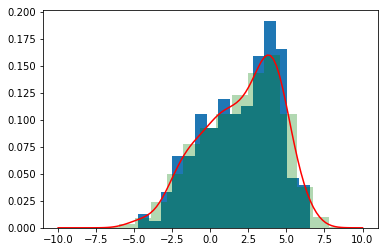

In [56]:
plt.hist(x, 15, normed=True);
plt.plot(xx, kde.evaluate(xx), c='r')
plt.hist(brute_force_draw(kde, N=10000), 15, color='g', normed=True, alpha=0.3)

# Do this in pymc3

In [57]:
def from_hist(param, kde, xlim=(-10,10), N=100):
    width = xlim[1] - xlim[0]
    x = np.linspace(xlim[0], xlim[1], N)
    y = kde.evaluate(x)
    
    # what was never sampled should have a small probability but not 0,
    # so we'll extend the domain and use linear approximation of density on it
    x = np.concatenate([[x[0] - 3 * width], x, [x[-1] + 3 * width]])
    y = np.concatenate([[0], y, [0]])
    return Interpolated(param, x, y)

In [58]:
model = Model()
with model:
    # Priors are posteriors from previous iteration
    dat = from_hist('dat', kde)

    # draw 10000 posterior samples
    trace = sample(10000)


Auto-assigning NUTS sampler...
Initializing NUTS using ADVI...
  0%|          | 0/200000 [00:00<?, ?it/s]
Convergence archived at 100
Interrupted at 100 [0%]: Average Loss = 9.7185
100%|██████████| 10500/10500 [00:08<00:00, 1202.53it/s]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1244d0c50>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x124587550>]], dtype=object)

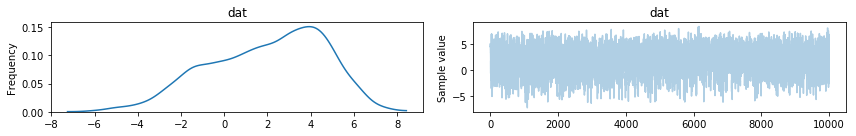

In [59]:
traceplot(trace)

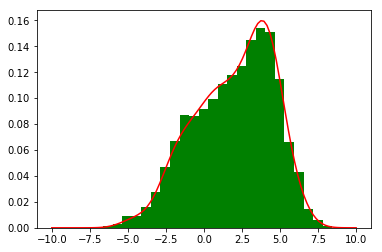

In [60]:
plt.plot(xx, kde.evaluate(xx), c='r')
plt.hist(trace['dat'], 25, normed=True, color='g');

# For the heck of it benchmark the brute_force_draw()

In [95]:
df = pd.DataFrame({'iter':[], 'time':[]})

In [101]:
import time
for _ in range(10):
    for i in np.logspace(2, 6, 15).astype(int):
        t0 = time.time()
        brute_force_draw(kde, N=i)
        t = time.time() - t0
        df = df.append({'iter':i, 'time':t}, ignore_index=True)


In [102]:
df.head()

,iter,time
0,100.0,0.028157
1,163.0,0.013186
2,268.0,0.013011
3,439.0,0.022207
4,719.0,0.017751


In [103]:
df.groupby('iter').mean()

,time
iter,
100.0,0.015709
163.0,0.016071
193.0,0.013737
268.0,0.018810
372.0,0.018922
439.0,0.019284
719.0,0.023510
1178.0,0.029916
1389.0,0.031592


RuntimeError: xdata and ydata must be the same length

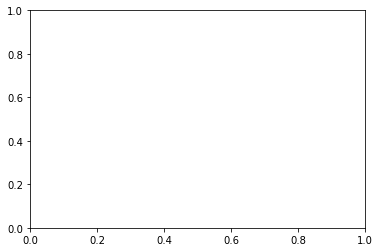

In [104]:
plt.errorbar(np.logspace(2, 6, 15).astype(int), df.groupby('iter').mean().as_matrix(), 
             yerr=df.groupby('iter').std().as_matrix())
plt.xscale('log')
plt.yscale('log')
plt.xlabel('N')
plt.ylabel('Time [s]')


In [ ]:
df.groupby('iter').std().as_matrix()